In [11]:
import sys
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/MEPS')
import netCDF4
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import colormaps as cmaps
import calc_date as cd
import save_fig as SF
import createFolder as cF
import calc_station_properties as cs
from matplotlib import gridspec



In [12]:
nc_dir = '../../Data/MRR/original_data/'

s_nc = 0
nc_save_dir = '../../Data/MRR/processed_MRR/'
cF.createFolder(nc_save_dir)

sfig = 0
fig_dir = '../../Figures/MRR_ref/'
cF.createFolder(fig_dir)
form = 'png'



year = '2016'
mon = '12'
t = ['20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
t = ['25']

fs = 22
#file_out = 'VMRR_data_%s%s%s.txt' %(year,mon,day)

In [13]:
date_blue = np.array([1,74,159])/255.           # for the date

def plt_refl(tid, h_mid, avgref, calday, day, calmon, year):
### plot reflectivity
    levels = np.arange(-10,30,0.2)

    fig = plt.figure(figsize=(20,7))
    gs = gridspec.GridSpec(7,1)

    ax0 = fig.add_subplot(gs[:6,:])
    CS = ax0.contourf(np.asarray(tid), np.asarray(h_mid) , np.asarray(avgref), 
                  levels, cmap='jet')
# add colorbar
    cbaxes = fig.add_axes([0.14, 0.1, .75, .02] )   #[left, bottom, width, height] 
    cbar = plt.colorbar(CS, orientation = 'horizontal', cax=cbaxes)
    cbar.ax.set_xlabel('MRR reflectivity [dBz]', fontsize = 22)
    cbar.ax.tick_params(labelsize = 20)

# labels
    times = [0, 3, 6, 9,12, 15, 18, 21, 24]
    ax0.set_xticks(np.arange(0,60*60*25,3*60*60))
    ax0.set_xticklabels(times, fontsize = 20)
    ax0.set_xlabel('time [hours]', fontsize = 22)

    ax0.set_ylabel('height [km]', fontsize = 22)
    ax0.set_ylim(0,3.5)
    ax0.set_yticks(np.arange(0,3500.,500.))
    yl = [0., '' , 1.0, '' , 2., '' , 3.]
    ax0.set_yticklabels(yl, fontsize = 20)
    
    
# textbox
    ax0.text(0.02,0.96, '%s, %s %s %s' %(calday, day, calmon, year), verticalalignment = 'top',  
         horizontalalignment='left',
             transform = ax0.transAxes,
            color =date_blue, fontsize=fs,
           bbox={'facecolor':'white','alpha':1., 'pad':10})



In [14]:
def read_and_mask(fn,var_name, fill_value):
    #### Read in variable 'Ze' (time = 1440,range = 31)
    var = fn.variables[var_name]
# fill value, where Ze = -9999, fill_value = -50.
    mask = np.ma.getmaskarray(var[:,:])
    var = np.ma.array(var[:,:], mask = mask, fill_value = fill_value)
    var = var.filled()
    return(var);

(1440, 14)


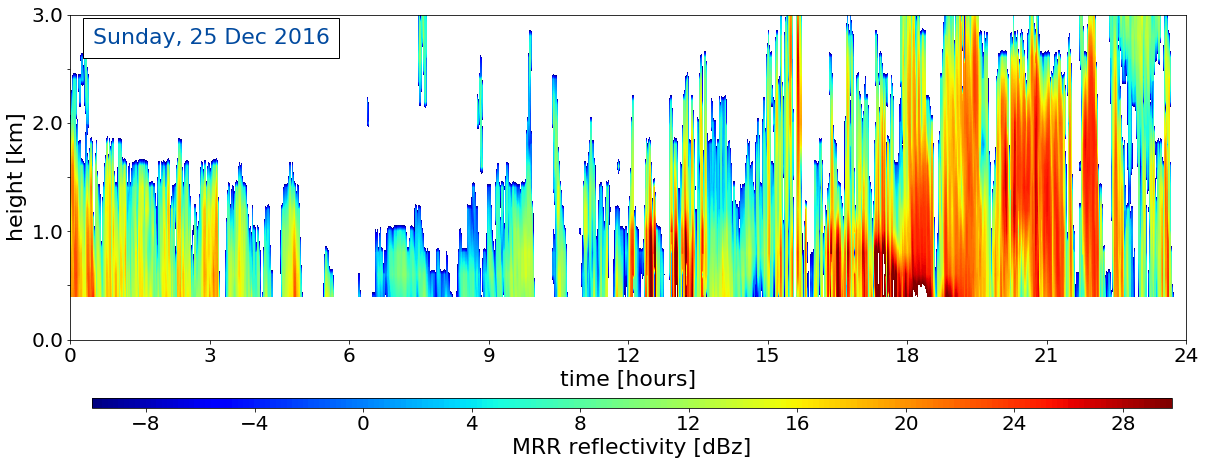

In [15]:
for day in t:
    fn = netCDF4.Dataset('%s/MRR_HKL_%s%s%s_maahn_r01.nc' %(nc_dir,year,mon,day) ,'r')


    calday, calmon = cd.get_dayname(year,mon,day)
    
# Read in varaibel 'time' (time=1440)
    time = fn.variables['time']


    netCDF4.num2date(time[:],time.units)

#### Read in variable 'Ze' (time = 1440,range = 31)
    Ze = read_and_mask(fn,'Ze', -50.)
    Z = 10**(Ze / 10.)
    
#### Read in variable 'W' (time = 1440, range= 31)
    W = read_and_mask(fn,'W', -9999)
    
#### Read in variable 'spectralWidth' (time = 1440, range= 31)
    spec_width = read_and_mask(fn,'spectralWidth', -9999)
    
################## calculate mean of variable, use values above 300m ####################
# no. of layers
    nlay = 14

# bottom of the layer(start of valid MRR measurements at 300) 
    bot = []
# top of the layer (layer thickness will be 200)
    top = []
    for k in range(0, nlay):
        bot.append(300.+ k*200)
        top.append(bot[k]+200)

# Read in variable 'height' (time =1440,range = 31)
    height = fn.variables['height']


    avg_ref = []
    avg_DoV = []
    avg_SW = []
    h_mid = []
    tid = []
    for i in range(0, height.shape[0]):
        for k in range(0, nlay):
            idx = np.where(np.logical_and(height[i,:] >= bot[k], height[i,:] < top[k]))
        # mean in layer
            res_Ze = np.mean(Z[i,idx])
            res_DoV = np.mean(W[i,idx])
            res_SW = np.mean(spec_width[i,idx])
        
        # average in layer 
            avg_ref.append(10*math.log10(res_Ze))     # in [dBz]
            avg_DoV.append((res_DoV))
            avg_SW.append((res_SW))
            
            
            h_mid.append((bot[k]+top[k])/2)
            tid.append(time[i]-time[0])


    avg_ref = np.split(np.asarray(avg_ref),height.shape[0])
    avg_DoV = np.split(np.asarray(avg_DoV), height.shape[0])
    avg_SW = np.split(np.asarray(avg_SW), height.shape[0])
    h_mid = np.split(np.asarray(h_mid),height.shape[0])

    tid = np.split(np.asarray(tid),height.shape[0])
    print(np.asarray(tid).shape)
    

### mask avg before netcdf saving
    avg_ref_masked = np.ma.masked_where(np.asarray(avg_ref) <= -50.0, np.asarray(avg_ref))
    avg_ref_masked = np.ma.array(avg_ref_masked, mask = np.ma.getmaskarray(avg_ref_masked), fill_value = -50.0)
    
    avg_DoV_masked = np.ma.masked_where(np.asarray(avg_DoV) <= -4000., np.asarray(avg_DoV))
    avg_DoV_masked = np.ma.array(avg_DoV_masked, mask = np.ma.getmaskarray(avg_DoV_masked), fill_value = -9999)

    avg_SW_masked = np.ma.masked_where(np.asarray(avg_SW) <= -4000., np.asarray(avg_SW))
    avg_SW_masked = np.ma.array(avg_SW_masked, mask = np.ma.getmaskarray(avg_SW_masked), fill_value = -9999)



    if s_nc == 1:
        
### write netCDF file including tid, h_mid, avgref
        f = netCDF4.Dataset('%s/VMRR_%s%s%s.nc' %(nc_save_dir,year,mon,day), 'w')

### create dimensions
        f.createDimension('time', np.asarray(tid)[:,0].shape[0])
        f.createDimension('height', np.asarray(h_mid)[0,:].shape[0])

        tt = f.createVariable('time', np.asarray(tid).dtype,'time',zlib = True)
        tt[:] = np.asarray(tid)[:,0]

        h = f.createVariable('height', np.asarray(h_mid).dtype, 'height', zlib=True)
        h[:] = np.asarray(h_mid)[0,:]

        dim = ('time', 'height')
        avg_Ze = cs.get_netCDF_variable(f,'Ze', avg_ref_masked,dim)
        avg_dopp_vel = cs.get_netCDF_variable(f,'mean_doppler_velocity', avg_DoV_masked,dim)
        avg_specWidth = cs.get_netCDF_variable(f, 'spectral_width', avg_SW_masked, dim)
        f.close()
    
    ### save figure of reflectivity
    
    if sfig == 1:
        fig_name = 'MRR_%s%s%s.%s' %(year,mon,day,form)
        plt_refl(tid, h_mid, avg_ref, calday, day, calmon, year)
        SF.save_figure_landscape(fig_dir, fig_name, form)
    else:
        plt_refl(tid, h_mid, avg_ref, calday, day, calmon, year)
        plt.show()
    plt.close()
    
    
    fn.close()

In [16]:
np.asarray(tid).max()

86340